In [148]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares, minimize
from helper.opinion_dynamics import DGModel, FJModel
from helper.clicking_functions import clicking_function_combined, minimize_combined_scalar_FJ, minimize_combined_scalar
import pandas as pd
import numpy as np
from matplotlib import pyplot
pyplot.rcParams['figure.dpi'] = 600
pyplot.rcParams['savefig.dpi'] = 600

In [149]:
def top_k_column_indices_match(matrix1, matrix2, k):
    # Compute column sums
    col_sums1 = np.sum(matrix1, axis=0)
    col_sums2 = np.sum(matrix2, axis=0)

    # Get indices of the k largest column sums
    top_k_indices1 = np.argsort(col_sums1)[-k:]
    top_k_indices2 = np.argsort(col_sums2)[-k:]

    # Return 1 if indices match, 0 otherwise
    return 1 if set(top_k_indices1) == set(top_k_indices2) else 0

def top_kappa_columns(M: np.ndarray, kappa: int):
    # compute column sums
    col_sums = M.sum(axis=0)

    # get indices of top-kappa sums
    top_indices = np.argsort(col_sums)[-kappa:]

    # build binary vector
    mask = np.zeros(M.shape[1], dtype=int)
    mask[top_indices] = 1

    return mask

    def plot_with_std(ratio, ratio_ofo, ratio_ideal, title, values=50):
      if len(ratio[0]) == 50:
          x = np.arange(50) * 100
      else:
          x = np.arange(len(ratio[0]))

      ratio = np.array(ratio)
      ratio_ideal = np.array(ratio_ideal)

      mean = ratio.mean(axis=0)
      std = ratio.std(axis=0)
      plt.plot(x, mean, color='blue')
      plt.fill_between(x, mean-std, mean+std,1, color="blue", alpha=0.2, label='Highest Col sum')

      mean = ratio_ofo.mean(axis=0)
      std = ratio_ofo.std(axis=0)
      plt.plot(x, mean, color='orange')
      plt.fill_between(x, mean-std, mean+std,1, color="orange", alpha=0.2, label='OFO with sensitivity estimation')

      mean = ratio_ideal.mean(axis=0)
      std = ratio_ideal.std(axis=0)
      plt.plot(x, mean, color='green')
      plt.fill_between(x, mean-std, mean+std,1, color="green", alpha=0.2, label='OFO with known sensitivity')


      plt.ylabel(title)
      plt.xlabel("Time step")
      plt.legend()
      plt.grid()
      plt.ylim(-0.1, 1.1)
      plt.show()

def plot_results(l, title, values = 50):
    if len(l[0]) == num_of_triggers:
        x = np.arange(num_of_triggers) * 100
    else:
        x = np.arange(len(l[0]))

    for i in range(values):
        plt.plot(x, l[i], color='0.8')

    plt.plot(x, np.mean(l, axis=0), linestyle="-", label='Mean')
    plt.ylabel(title)
    plt.xlabel("Time steps")
    plt.xlim(0, simulation_steps)
    plt.ylim(0, 180)
    plt.legend()
    plt.grid()
    plt.show()

def plot_theta(l, title, values = 50):
    if len(l[0]) == num_of_triggers:
        x = np.arange(num_of_triggers) * 100
    else:
        x = np.arange(len(l[0]))

    for i in range(values):
        plt.plot(x, l[i], color='0.8')

    plt.plot(x, np.mean(l, axis=0), linestyle="-", label='Mean')
    plt.ylabel(title)
    plt.xlabel("Time steps")
    plt.xlim(0, simulation_steps)
    plt.ylim(0, 60)
    plt.legend()
    plt.grid()
    plt.show()


def plot_with_std(ratio, ratio_ofo, ratio_ideal, title, values=50):
    if len(ratio[0]) == num_of_triggers:
        x = np.arange(num_of_triggers) * 100
    else:
        x = np.arange(len(ratio[0]))

    ratio = np.array(ratio)
    ratio_ofo = np.array(ratio_ofo)
    ratio_ideal = np.array(ratio_ideal)

    mean = ratio.mean(axis=0)
    std = ratio.std(axis=0)
    plt.plot(x, mean, color='blue')
    plt.fill_between(x, mean-std, mean+std, color="blue", alpha=0.2, label='Greedy with sensitivity estimation')

    mean = ratio_ofo.mean(axis=0)
    std = ratio_ofo.std(axis=0)
    plt.plot(x, mean, color='orange')
    plt.fill_between(x, mean-std, mean+std, color="orange", alpha=0.2, label='OFO with sensitivity estimation')

    mean = ratio_ideal.mean(axis=0)
    std = ratio_ideal.std(axis=0)
    plt.plot(x, mean, color='green')
    plt.fill_between(x, mean-std, mean+std, color="green", alpha=0.2, label='OFO with known sensitivity')


    plt.ylabel(title)
    plt.xlabel("Time step")
    plt.legend()
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.show()

In [150]:
# Parameters
#np.random.seed(41)
np.set_printoptions(precision=4, suppress=True)
simulation_steps = 7500
num_of_triggers = simulation_steps//100
d = 5
W = 20
kappa = 2 # L1 constraint on P
const_A = False
flip_A = False

records = []


In [183]:
runs = 2
precision_influencer = np.zeros(runs)
precision_influencer_ofo = np.zeros(runs)
for run in range(runs):
    print("Run", run + 1)

    # Fixed matrix and parameters
    A = np.array([[0.15, 0.15, 0.1, 0.2, 0.4],[0, 0.55, 0, 0, 0.45],[0.3, 0.05, 0.05, 0, 0.6],[0, 0.4, 0.1, 0.5, 0],[0, 0.3, 0, 0, 0.7]])
    x_0 = np.random.uniform(-1, 1, d)
    p_0 = np.zeros(d)
    gamma_p = np.random.uniform(0.01, 0.5, d)
    gamma_d = np.random.uniform(0.01, 0.25, d)
    disturb = np.random.normal(0, 0.2, d)
    sim = FJModel(N=d, gamma_p=gamma_p, gamma_d=gamma_d, A=A, x_0=x_0, d=disturb)
    sim_ofo = FJModel(N=d, gamma_p=gamma_p, gamma_d=gamma_d, A=A, x_0=x_0, d=disturb)
    sim_ideal = FJModel(N=d, gamma_p=gamma_p, gamma_d=gamma_d, A=A, x_0=x_0, d=disturb)
    theta = np.random.uniform(0, 1, d)

    #print("True theta:", theta)
    #print("True row sums: \n", sim.get_sensitivity().sum(axis=1))

    feedforward_p = top_kappa_columns(sim.get_sensitivity(), kappa)
    feedforwar_cost = np.sum(sim.get_sensitivity() @ feedforward_p + sim.get_disp_sensitivity() @ sim.d)

    #print("Optimal p:", feedforward.x)
    #print("Optimal x:", sim.get_sensitivity() @ feedforward.x)
    #print("Cost function:", -1*feedforward.fun)


    # Storage for results
    CTR_obs = np.zeros((num_of_triggers, d))  # Observed CTRs
    CTR_obs_OFO = np.zeros((num_of_triggers, d))  # Observed CTRs
    CTR_obs_ideal = np.zeros((num_of_triggers, d))  # Observed CTRs
    X = np.zeros((simulation_steps + 1, d))
    X_OFO = np.zeros((simulation_steps + 1, d))
    X_ideal = np.zeros((simulation_steps + 1, d))
    X[0] = x_0
    X_OFO[0] = x_0
    X_ideal[0] = x_0
    P = np.zeros((num_of_triggers + 1, d))
    P_OFO = np.zeros((num_of_triggers + 1, d))
    P_ideal = np.zeros((num_of_triggers + 1, d))
    P[0] = p_0
    P_OFO[0] = p_0
    P_ideal[0] = p_0

    rel_sensitivity_error_diag = np.zeros(num_of_triggers)
    rel_sensitivity_error_diag_ofo = np.zeros(num_of_triggers)
    rel_theta_error = np.zeros(num_of_triggers)
    rel_theta_error_ofo = np.zeros(num_of_triggers)

    performance_ratio_ideal = np.zeros(simulation_steps)
    performance_ratio = np.zeros(simulation_steps)
    performance_ratio_ofo = np.zeros(simulation_steps)

    #cost_difference = np.zeros(simulation_steps)

    estimated_theta = 0.5*np.ones(d)
    estimated_epsilon = np.zeros(d)
    estimated_sensitivity = np.eye(d).flatten(order='C')
    estimated_theta_ofo = 0.5*np.ones(d)
    estimated_epsilon_ofo = np.zeros(d)
    estimated_sensitivity_ofo = np.eye(d).flatten(order='C')

    trigger = 0
    start_range = 0
    for i in range(simulation_steps):
        #cost_difference[i] = abs(np.sum(X[i]) - np.sum(X_ideal[i]))
        #if(np.sum(X[i]) > (feedforwar_cost)):
        #    print(np.sum(X[i]), feedforwar_cost, P[trigger])
        #    print(np.sum(sim.get_sensitivity() @ P[trigger] + sim.get_disp_sensitivity() @ sim.d))
        performance_ratio[i] = np.sum(X[i]) / (feedforwar_cost)
        performance_ratio_ofo[i] = np.sum(X_OFO[i]) / (feedforwar_cost)
        performance_ratio_ideal[i] = np.sum(X_ideal[i]) / (feedforwar_cost)

        if i % 100 <= 40:  # First 20 steps: give time to converge
            X[i + 1] = sim.update(p=P[trigger])
            X_OFO[i + 1] = sim_ofo.update(p=P_OFO[trigger])
            X_ideal[i + 1] = sim_ideal.update(p=P_ideal[trigger])

        else: # Last 60 steps: measure CTR
            CTR_obs[trigger] += np.random.rand() < clicking_function_combined(P[trigger], X[i], theta=theta)
            CTR_obs_OFO[trigger] += np.random.rand() < clicking_function_combined(P_OFO[trigger], X_OFO[i], theta=theta)
            CTR_obs_ideal[trigger] += np.random.rand() < clicking_function_combined(P_ideal[trigger], X_ideal[i], theta=theta)
            X[i + 1] = sim.update(p=P[trigger])
            X_OFO[i + 1] = sim_ofo.update(p=P_OFO[trigger])
            X_ideal[i + 1] = sim_ideal.update(p=P_ideal[trigger])


            if i % 100 == 99: # End of trigger period: average CTR, estimate sensitivity and choose new P
                #print("Trigger", trigger + 1)
                CTR_obs[trigger] /= 60
                CTR_obs_OFO[trigger] /= 60
                CTR_obs_ideal[trigger] /= 60
                #print("Observed CTR:", CTR_obs[trigger])
                #print("Ideal CTR:", clicking_function_combined(P[trigger], X[i], theta=theta))

                if not const_A:
                    start_range = max(0, trigger - W)


                constraints = [
                    {'type': 'ineq',
                    'fun': lambda params, i=i: 1 - np.sum(params[i*d:(i+1)*d])}
                    for i in range(d)
                ]

                # diagonal dominance constraints: S_ii >= S_ji for all j != i
                for i in range(d):  # for each column i
                    diag_idx = i * d + i
                    for j in range(d):
                        if j != i:
                            off_idx = j * d + i
                            constraints.append({
                                'type': 'ineq',
                                'fun': lambda params, diag_idx=diag_idx, off_idx=off_idx: params[diag_idx] - params[off_idx]
                            })

                #result = minimize(minimize_combined_scalar, np.concatenate((estimated_sensitivity, estimated_theta)), bounds=[(0, 1)]*(d*d + d), constraints=constraints, args=(d, P[start_range:trigger+1], CTR_obs[start_range:trigger+1]), method='SLSQP', options={'maxiter': 1000})
                result = minimize(minimize_combined_scalar_FJ, np.concatenate((estimated_sensitivity, estimated_theta, estimated_epsilon)), bounds=[(0, 1)]*(d*d + 2*d), constraints=constraints, args=(d, P[start_range:trigger+1], CTR_obs[start_range:trigger+1]), method='SLSQP', options={'maxiter': 1000})
                result_ofo = minimize(minimize_combined_scalar_FJ, np.concatenate((estimated_sensitivity_ofo, estimated_theta_ofo, estimated_epsilon_ofo)), bounds=[(0, 1)]*(d*d + 2*d), constraints=constraints, args=(d, P_OFO[start_range:trigger+1], CTR_obs_OFO[start_range:trigger+1]), method='SLSQP', options={'maxiter': 1000})

                #print("Optimization success:", result.success, "Message:", result.message)
                result = result.x
                result_ofo = result_ofo.x

                estimated_sensitivity = result[:d*d]
                estimated_sensitivity[np.abs(estimated_sensitivity) < 1e-10] = 0
                estimated_sensitivity_matrix = estimated_sensitivity.reshape((d, d), order='C')
                estimated_theta = result[d*d:d*d + d]

                estimated_sensitivity_ofo = result_ofo[:d*d]
                estimated_sensitivity_ofo[np.abs(estimated_sensitivity_ofo) < 1e-10] = 0
                estimated_sensitivity_matrix_ofo = estimated_sensitivity_ofo.reshape((d, d), order='C')
                estimated_theta_ofo = result_ofo[d*d:d*d + d]

                rel_sensitivity_error_diag[trigger] = 100 * np.linalg.norm(np.diag(estimated_sensitivity_matrix - sim.get_sensitivity()), ord=1) / np.linalg.norm(np.diag(sim.get_sensitivity()), ord=1)
                rel_theta_error[trigger] = 100 * np.linalg.norm(estimated_theta - theta, ord=1) / np.linalg.norm(theta, ord=1)
                precision_influencer[run] += top_k_column_indices_match(sim.get_sensitivity(), estimated_sensitivity_matrix, kappa)

                rel_sensitivity_error_diag_ofo[trigger] = 100 * np.linalg.norm(np.diag(estimated_sensitivity_matrix_ofo - sim.get_sensitivity()), ord=1) / np.linalg.norm(np.diag(sim.get_sensitivity()), ord=1)
                rel_theta_error_ofo[trigger] = 100 * np.linalg.norm(estimated_theta_ofo - theta, ord=1) / np.linalg.norm(theta, ord=1)
                precision_influencer_ofo[run] += top_k_column_indices_match(sim.get_sensitivity(), estimated_sensitivity_matrix_ofo, kappa)


                P[trigger + 1] = sim.col_sensitivity(sensitivity=estimated_sensitivity_matrix, constraint=kappa)
                P_OFO[trigger + 1] = sim_ofo.ofo_sensitivity(P_OFO[trigger],sensitivity=estimated_sensitivity_matrix, constraint=kappa)
                P_ideal[trigger + 1] = sim_ideal.ofo(P_ideal[trigger], kappa)
                trigger += 1

                if not const_A:
                    sim.evolve_A()

                if i == simulation_steps//2 and flip_A:
                    sim.A[[1,4]] = sim.A[[4,1]]

    precision_influencer[run] = (precision_influencer[run] / num_of_triggers) * 100
    records.append({"rel_sensitivity_error": rel_sensitivity_error_diag, "rel_theta_error": rel_theta_error, "rel_sensitivity_error_ofo": rel_sensitivity_error_diag_ofo, "rel_theta_error_ofo": rel_theta_error_ofo,
                    "performance_ratio": performance_ratio, "performance_ratio_ideal": performance_ratio_ideal, "performance_ratio_ofo": performance_ratio_ofo})


print("Right influencer detected in percent", precision_influencer)
print("Right influencer detected in percent OFO", precision_influencer_ofo)

Run 1
Run 2
Right influencer detected in percent [1.3333 1.3333]
Right influencer detected in percent OFO [16. 23.]


In [187]:
df = pd.DataFrame(records)
df = df.drop(3)
df = df.drop(9)


In [186]:
df["rel_sensitivity_error"][9]

array([239.1289, 239.1289, 175.8634, 129.1335, 136.8516, 147.509 ,
       134.7908, 142.7849, 144.2929, 131.3742, 139.03  , 123.4079,
       127.9583, 123.0649, 129.4593, 121.9895, 123.9851, 144.6275,
       139.5226, 146.3931, 136.084 , 128.7342, 139.1061, 122.8536,
       127.7104, 126.3603, 137.7769, 145.0933, 116.5551, 116.5548,
       116.5548, 117.2924, 124.6907, 120.7674, 122.675 , 122.675 ,
       122.675 , 122.675 , 122.675 , 122.2834, 122.2834, 125.7347,
       122.163 , 118.8975, 118.8974, 118.8973, 118.8973, 131.3516,
       145.4417, 150.225 , 144.4632, 141.9992, 143.6408, 138.6765,
       152.1295, 152.1355, 144.155 , 137.4326, 170.1534, 151.3076,
       151.3077, 151.3077, 164.4127, 148.6365, 156.4617, 158.0252,
       157.7867, 157.7866, 150.6623, 156.5262, 154.3734, 139.7327,
       148.5019, 129.8531, 139.0986])

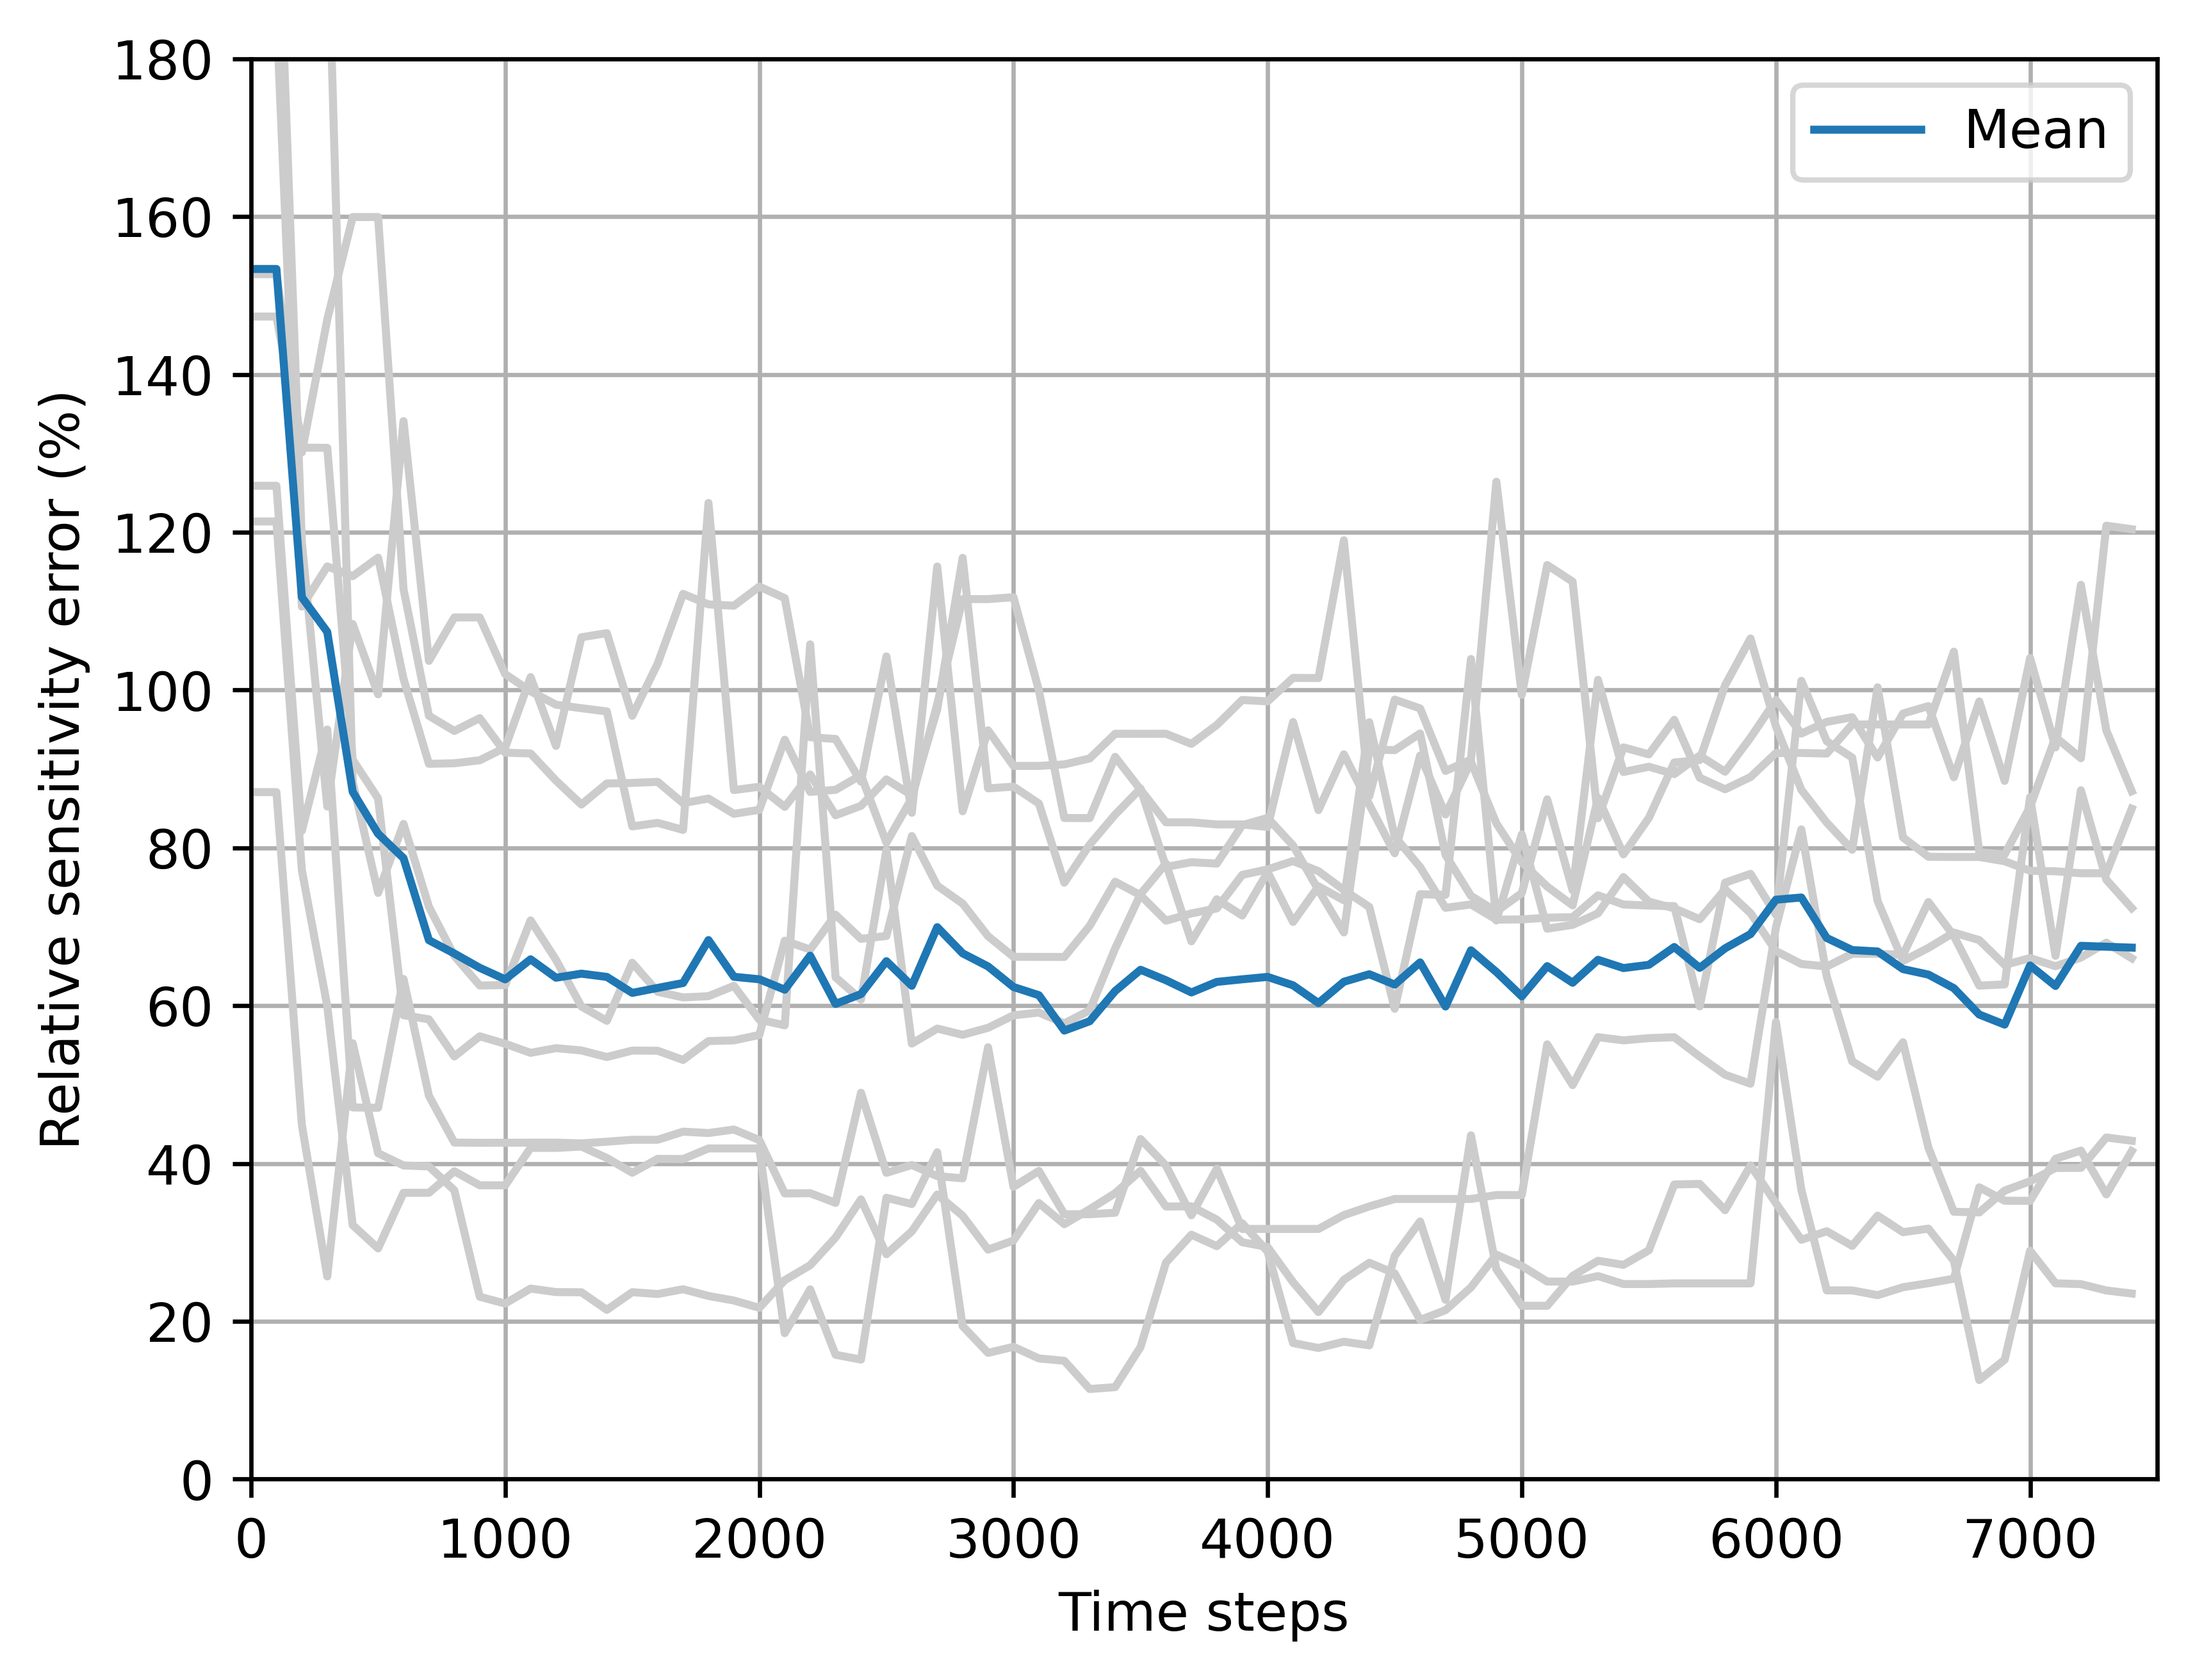

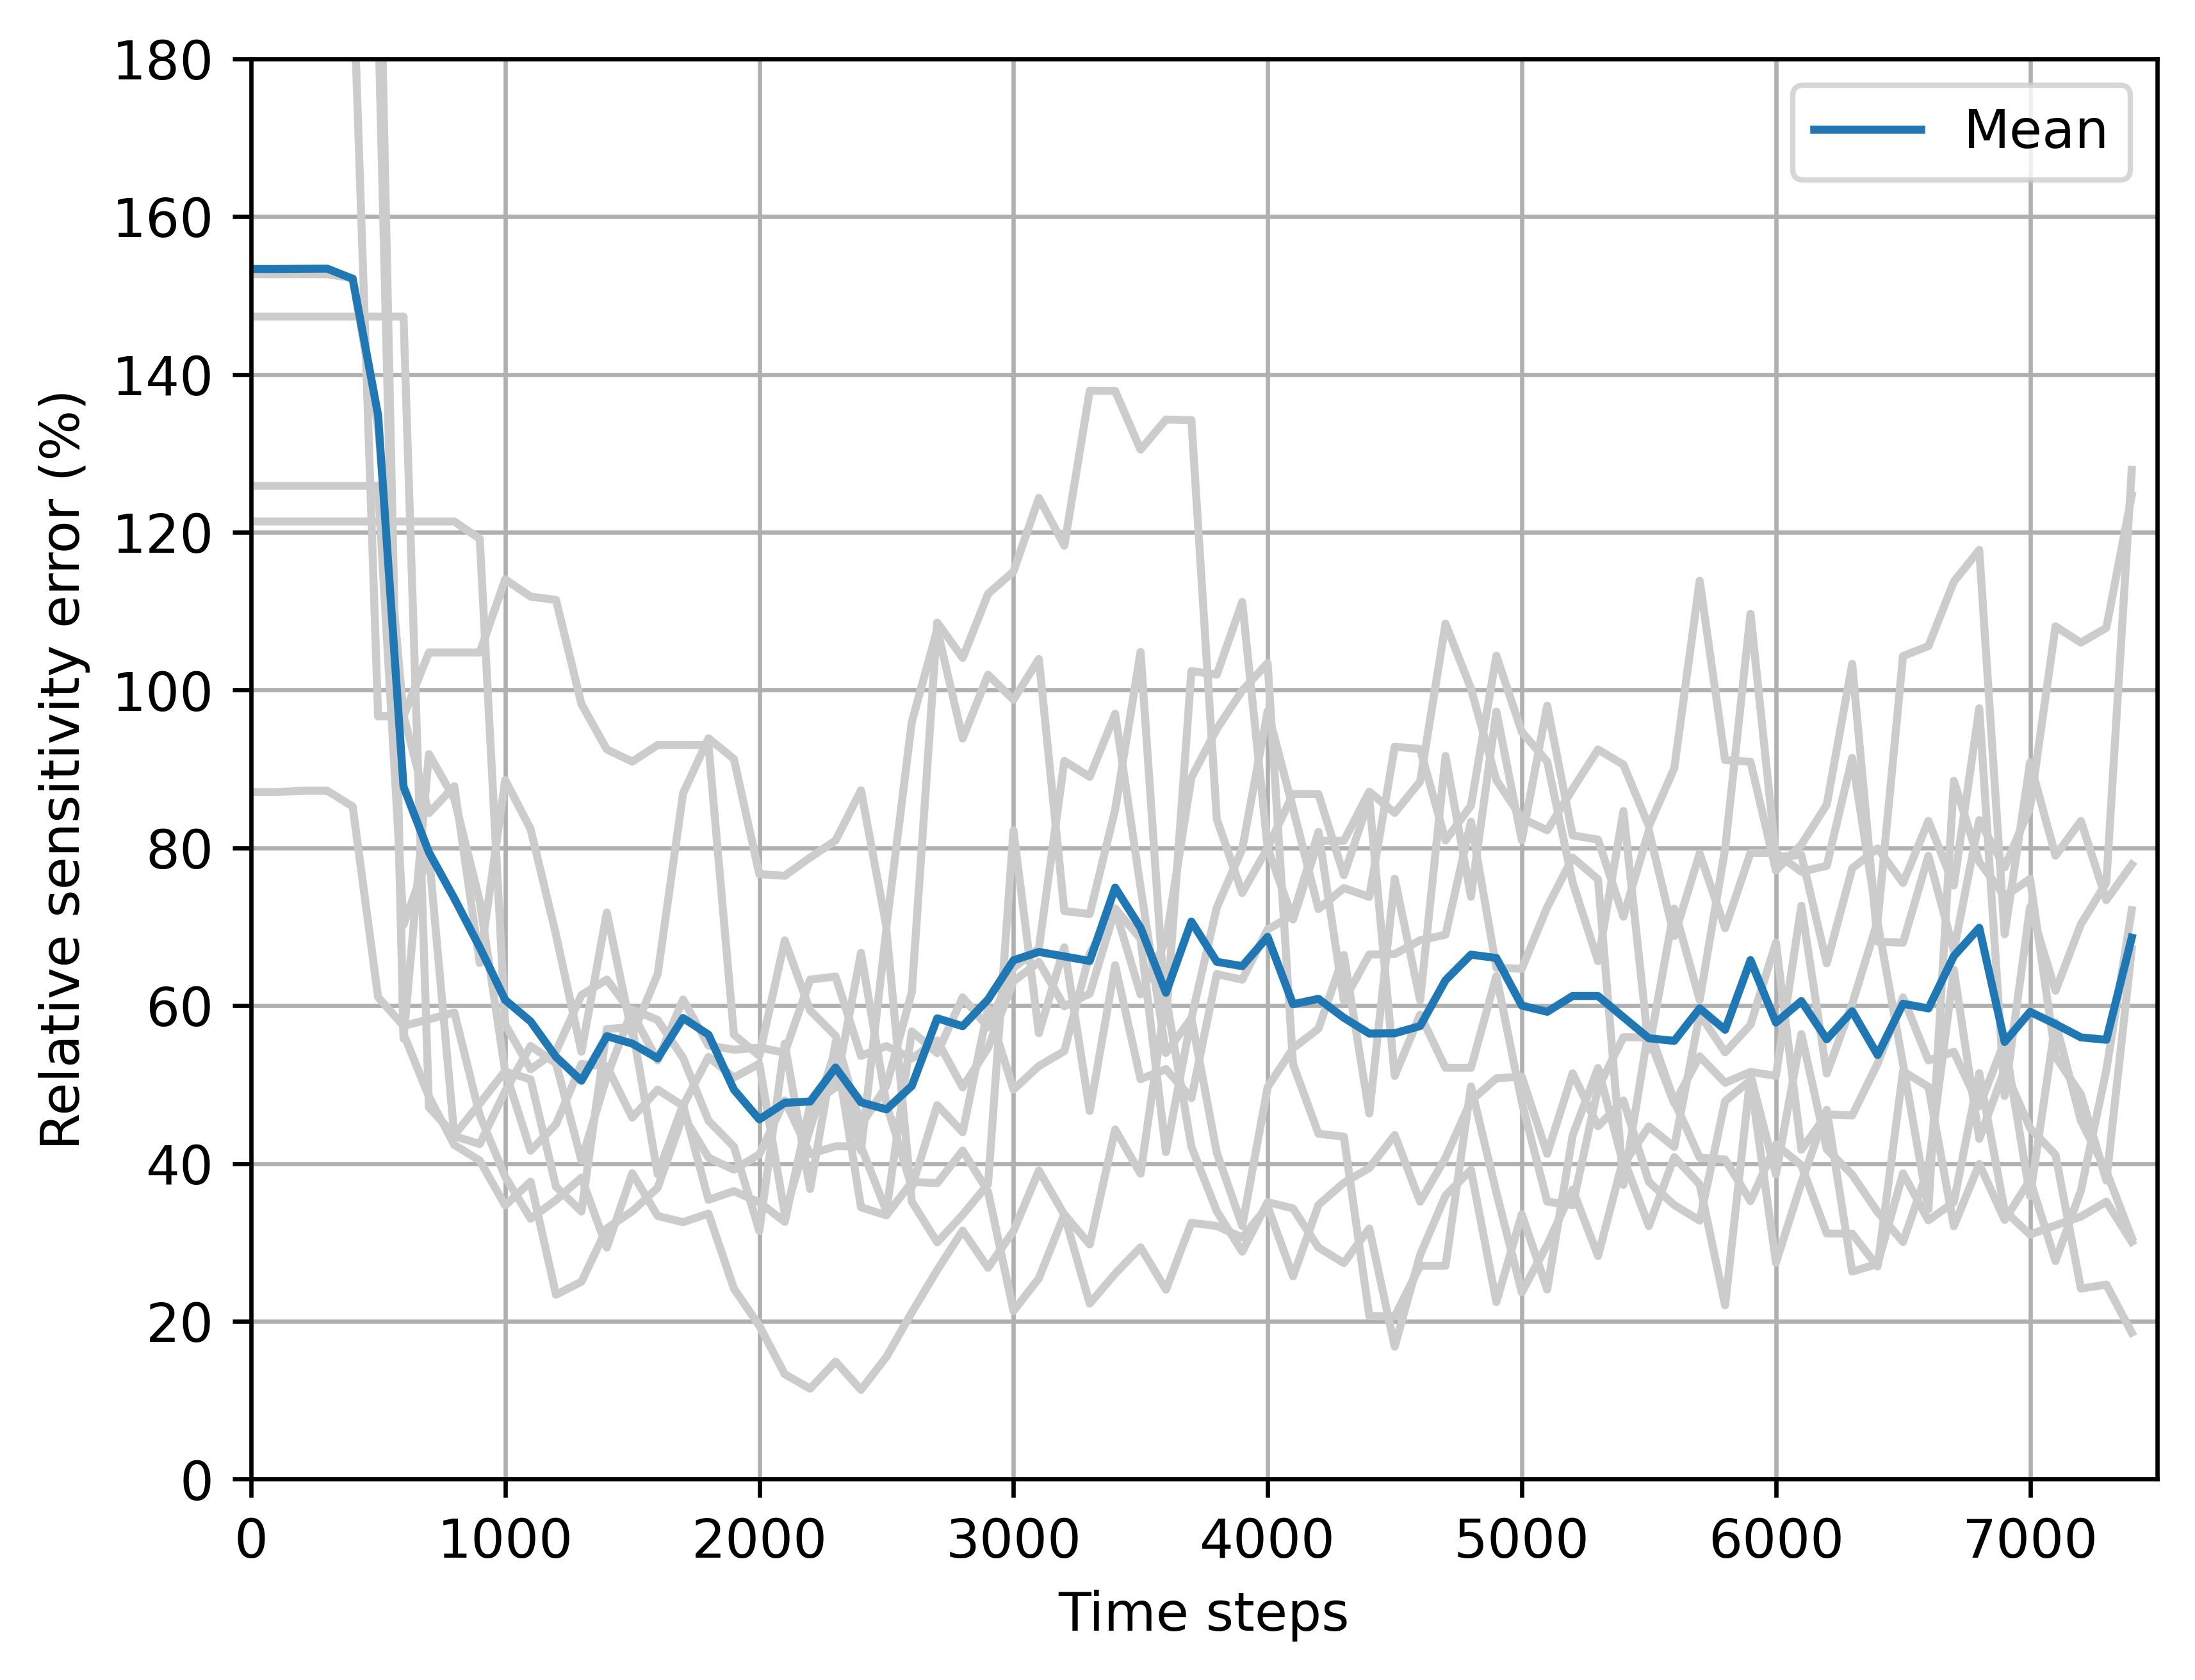

In [188]:
runs = 8
runs_sens = runs

plot_results(df['rel_sensitivity_error'].tolist(), title='Relative sensitivity error (%)', values=runs_sens)
plot_results(df['rel_sensitivity_error_ofo'].tolist(), title='Relative sensitivity error (%)', values=runs_sens)


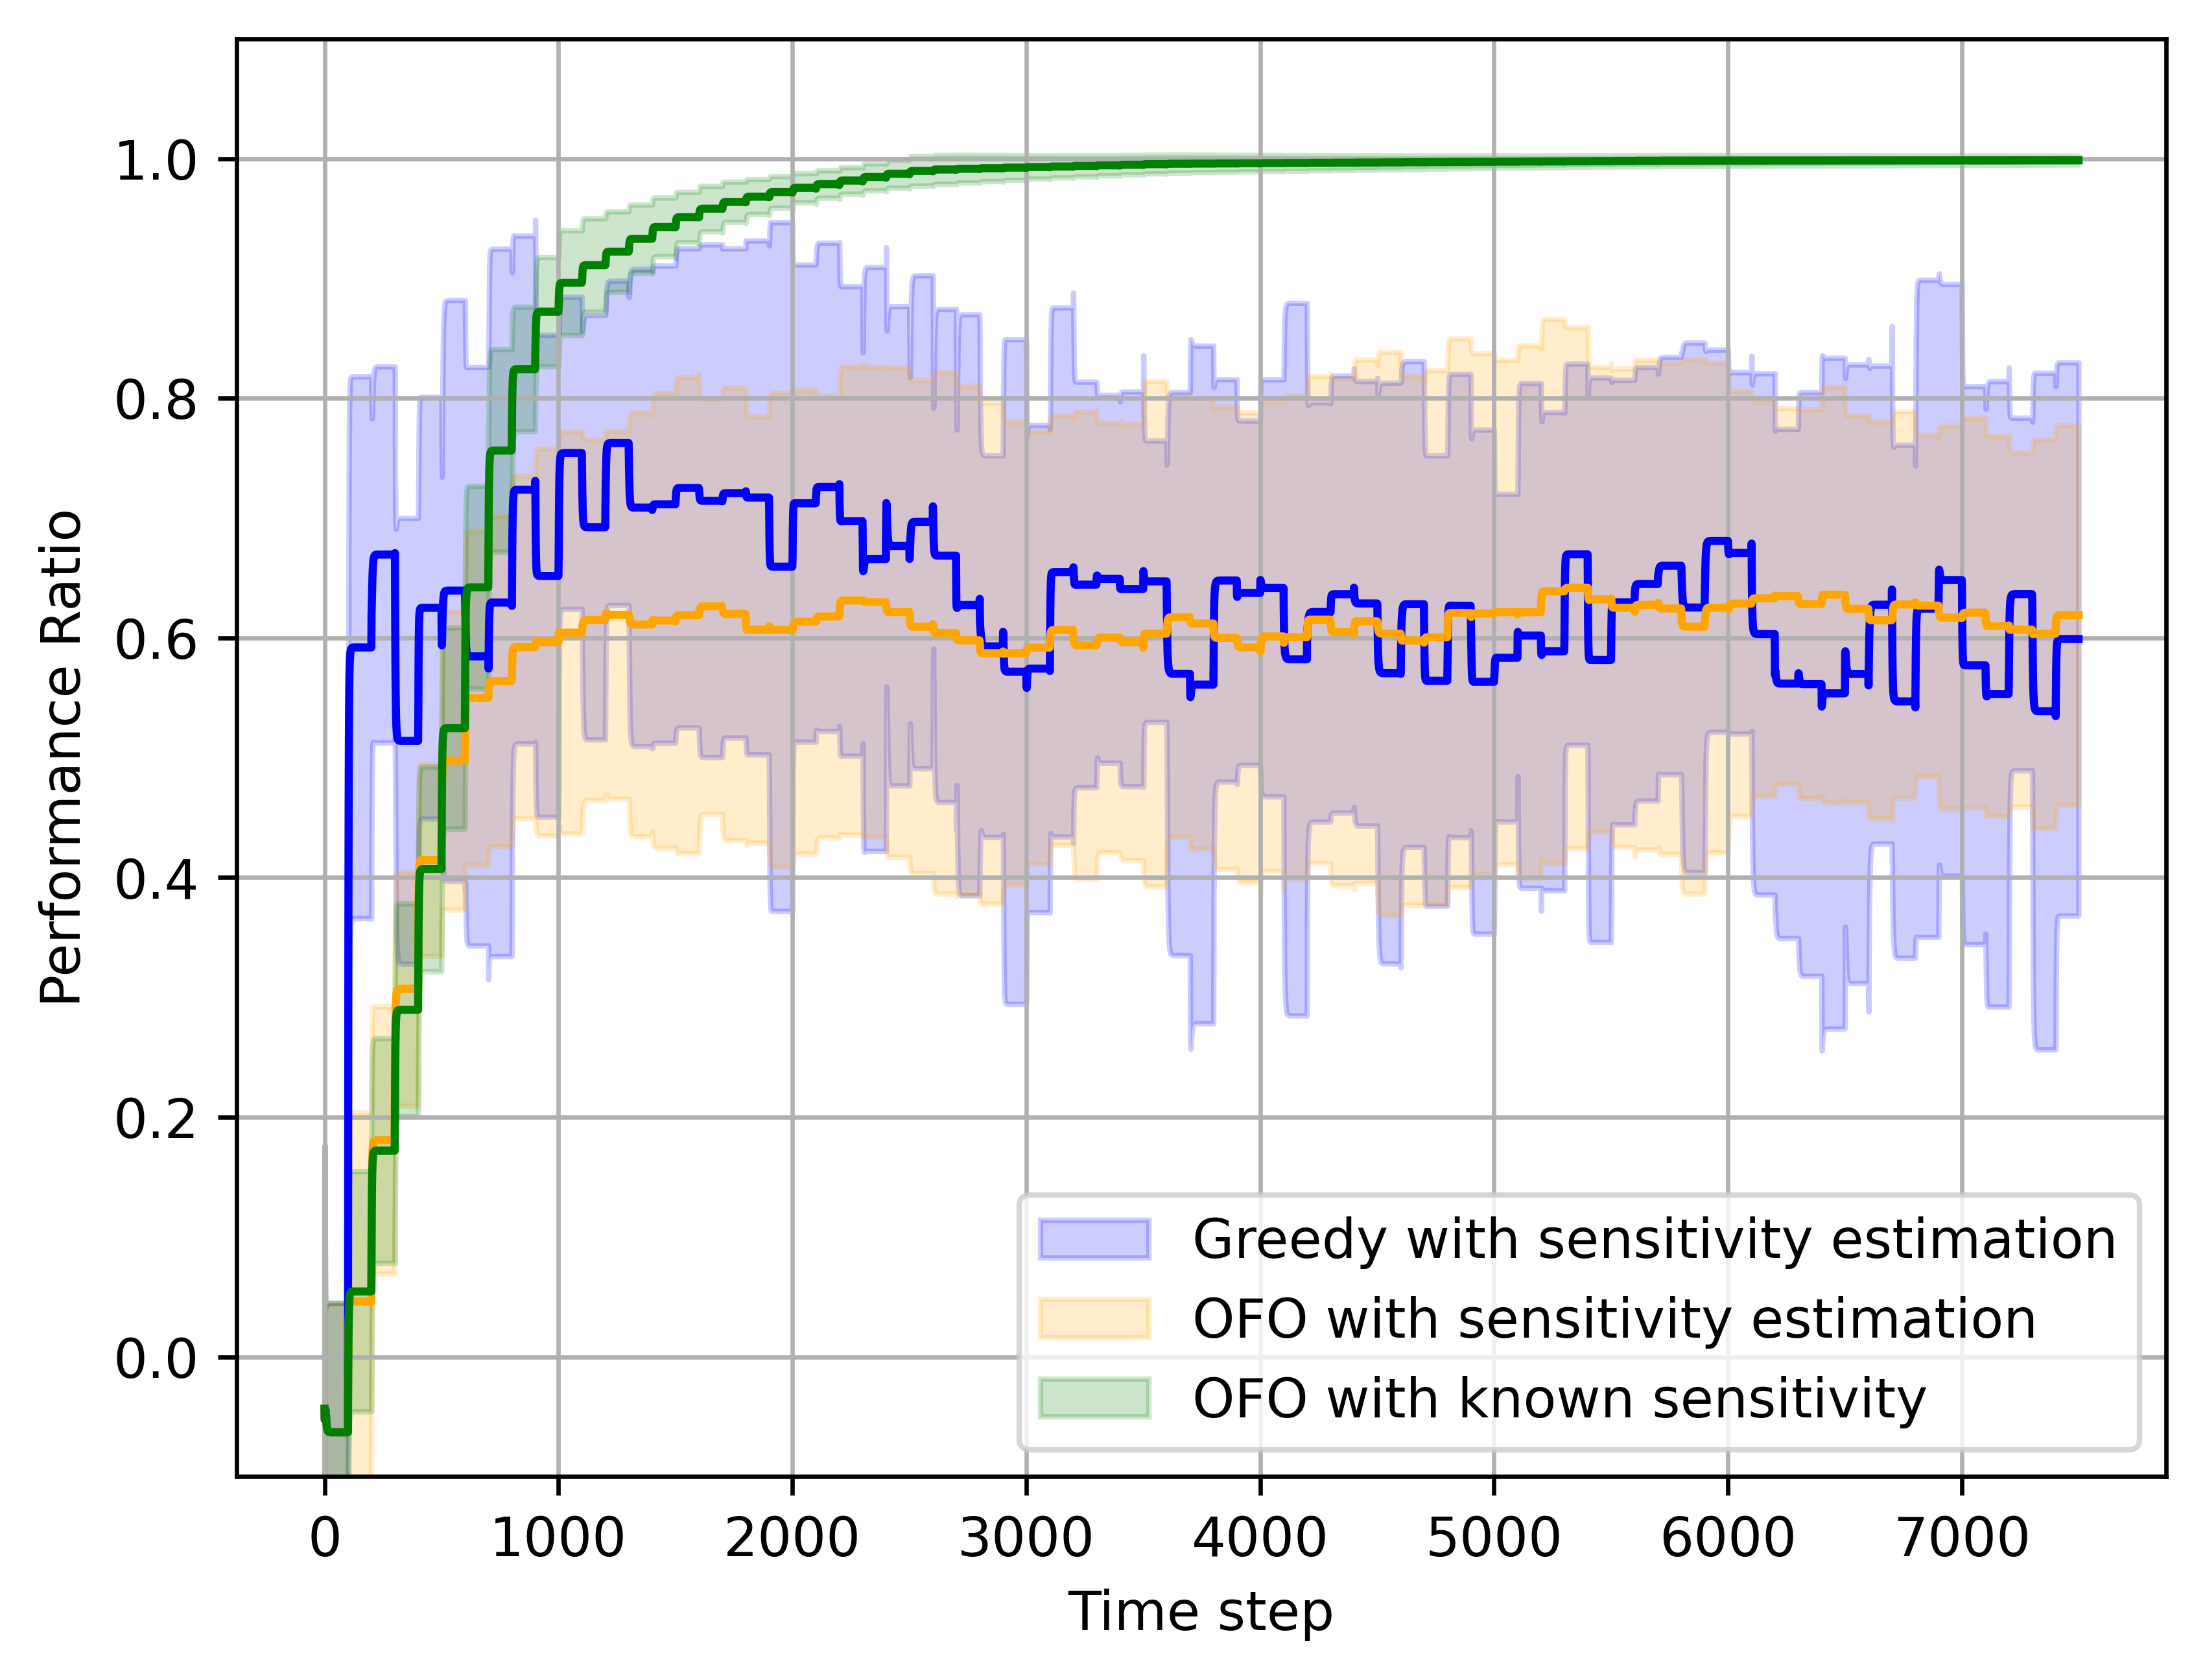

In [189]:
df_std = df
runs_std = runs

plot_with_std(df_std['performance_ratio'].tolist(), df_std['performance_ratio_ofo'].tolist(), df_std['performance_ratio_ideal'].tolist(), title="Performance Ratio", values=runs_std)
